# Lab 3C: Simple Neural Network in Python/NumPy (instead of using TensorFlow)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import tensorflow as tf

from lib.lab_utils_common import dlc, sigmoid
from lib.lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Load Data

In [38]:
# use capital letters for matrices; lowercase letters for vectors/scalars
X, Y = load_coffee_data()

# 200 rows/examples; 2 features per example in the input; 1 value per example in the output
print(X.shape, Y.shape)

print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

(200, 2) (200, 1)
Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51


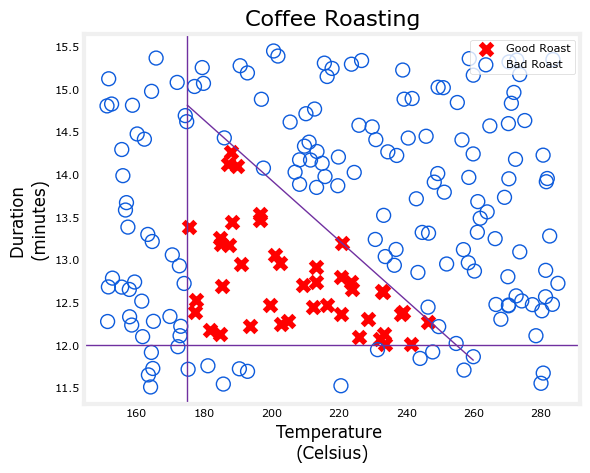

In [39]:
plt_roast(X,Y)

## Normalize the data

See Lab2B for more detail/breakdown on this.

In [40]:
norm_l = tf.keras.layers.Normalization(axis=-1)

norm_l.adapt(X)  # learns mean, variance

Xn = norm_l(X) # normalized input values

print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


## Define a function for handling each layer

In [101]:
# define the activation function g
# This should be a sigmoid function because we are doing classification.
# sigmoid is implemented in lab_utils_common; we simply rename the function here
g = sigmoid

In [132]:
# for a single layer, combine functions and activations
# W is a matrix of weights for this layer; rows = features for this layers (number of outputs from previous layer); cols = units for this layer
def my_dense(a_in, W, b):
    # print("\nentering my dense with variables:")
    # print(a_in) # This has two rows instead of 1!!! 
    # print(W)
    # print(b)
    
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
    Returns
      a_out (ndarray (j,))  : j units|
    """

    unit_count = W.shape[1]
    
    # make dummy array to accumulate results
    a_out = np.zeros(unit_count)

    # each loop represents one unit/function of the layer
    for j in range(unit_count):
        # print(f"on unit {j}")
        
        weights_for_this_unit = W[:,j] # accesses the jth column of the weights matrix... the weights for the unit j
        
        z = np.dot( weights_for_this_unit, a_in) + b[j]  # analogous to f(x) = wx + b
        
        a_out[j] = g(z) # sigmoid because doing classification; NB: you could pass g in as a parameter to this function
        # print(a_out)
    
    return a_out

## Define a function for building the neural network (multiple layers)

In [133]:
# defines a network with 2 layers
# W1 and W2 are the matrices of weights for layers 1 and 2, respectfully
# a_in is the matrix of original inputs; rows = examples; cols = features
def my_sequential(a_in, W1, b1, W2, b2):
    # print("\n Building layer 1")
    a1 = my_dense(a_in, W1, b1)

    # print("\n Building layer 2")
    a2 = my_dense(a1, W2, b2)

    return a2

## Make predictions

In [134]:
# Define prediction function
# This mimics model.predict().

# takes in matrix of new inputs (rows = examples; cols = features)
# returns matrix of predictions (1 column; same number of rows as input matrix)
def my_predict(X, W1, b1, W2, b2):
    new_input_count = X.shape[0]

    # make dummy matrix to accumulate results; 1 result per training example
    predictions = np.zeros((new_input_count, 1))

    # for each training example
    for i in range(new_input_count):
        # print(f"\n Making predictions for example {i}")
        
        # my_matrix[i, 0] is equivalent to matrix[i][0]
        # call my_sequential with 1 training example at a time (X[i])
        predictions[i, 0] = my_sequential(X[i], W1, b1, W2, b2)

    return predictions

In [135]:
# Create new inputs (from which to make predictions)
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example

# Remember to normalize the new inputs
X_tstn = norm_l(X_tst) 

In [136]:
# Use the trained weights and biases from lab 2B
# In lab 2B, we used Tensorflow to optimize the weights and biases. We will insert those weights and biases into the custom-defined functions above.

W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

In [137]:
# Use custom-defined function to make predictions
numeric_predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

print(f"\n\nnumeric_predictions: \n{numeric_predictions}")



numeric_predictions: 
[[9.72e-01]
 [3.29e-08]]


/var/folders/3b/hnpmysn502s9yzmj7cnm06_r0000gn/T/ipykernel_85822/1485847316.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[i, 0] = my_sequential(X[i], W1, b1, W2, b2)


In [138]:
# Convert numeric result (between 0 and 1) to binary result: 0 or 1

def make_binary_predictions(numeric_prediction_matrix):

    # placeholder matrix to be populated below
    y_hat = np.zeros_like(numeric_prediction_matrix)

    for i, prediction in enumerate(numeric_prediction_matrix):
        if prediction >= 0.5:
            y_hat[i] = 1
        else:
            y_hat[i] = 0 # probably unnecessary because existing values are already 0

    return y_hat

    
binary_predictions = make_binary_predictions(numeric_predictions)
print(f"\n\nbinary_predictions: \n{binary_predictions}")



binary_predictions: 
[[1.]
 [0.]]


In [139]:
# More succint version
def make_binary_predictions_succinct(numeric_prediction_matrix):
    y_hat = (predictions >= 0.5).astype(int)
    return y_hat

    
binary_predictions_succinct = make_binary_predictions_succinct(numeric_predictions)
print(f"\n\nbinary_predictions: \n{binary_predictions_succinct}")



binary_predictions: 
[[1]
 [1]]


### Visualize the layers combined (identical to lab 2B)

The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.

The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.

The following takes a moment to run. Do NOT run this locally.

In [ ]:
netf= lambda x : my_predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)